## Изчитане на уникалните плочки в корпуса

Нека премахнем всички празни плочки освен първата. Ще считаме останалите за уникални (което е почти вярно). След това ще съпоставим на всяка от тях число.

Ще направим и два речника:
  - от плочка към индекса ѝ
  - от индекс към плочка

In [1]:
import sys

sys.path.append('../model')

from tileset import *

jungle_tiles = Tileset.JUNGLE.tiles
print('All tiles:', len(jungle_tiles))
unique_tiles = [jungle_tiles[0]] + [tile for tile in jungle_tiles if not tile.is_empty]
print('Unique tiles:', len(unique_tiles))

All tiles: 25248
Unique tiles: 5308


In [2]:
import collections

int_to_tile = {}
tile_to_int = collections.defaultdict(lambda: 0)

for i, tile in enumerate(unique_tiles):
    int_to_tile[i] = tile
    tile_to_int[tile] = i

## Изчитане на корпуса

Ще изчетем всички карти с конкретен набор плочки. Това ще бъде корпусът ни. От там ще изваждаме контекст за думите.

In [3]:
import os

import config
from scenario import *

scenarios = []
scenarios += process_scenarios(os.path.join(config.STARCRAFT_ROOT, 'Maps'))
for directory in config.MAP_DIRECTORIES:
    scenarios += process_scenarios(directory)

scenarios = [s for s in scenarios if s.tileset == Tileset.JUNGLE]

In [4]:
len(scenarios)

224

In [5]:
sum(s.width * s.height for s in scenarios)

4938752

Пет милиона плочки в корпуса не звучи зле. Би трябвало да можем да научим някакъв контекст.

## Извличане на контекст

Функцията `get_target` ще излича контекст за плочка с координати (`height`, `width`) в картата `scenario`. Контекстът ще се извлича от плочки в околност с произволен радиус. В дългосрочен план, при трениране, това ще даде по-голяма тежест на по-близки съсдени плочки.

В масива `weights` е кодирана вероятността плочка да се падне в извличания контекст.

In [209]:
import numpy as np

weights = np.array([[5, 4, 3, 4, 5],
                    [4, 2, 1, 2, 4],
                    [3, 1, 0, 1, 3],
                    [4, 2, 1, 2, 4],
                    [5, 4, 3, 4, 5]])

def get_target(scenario, height, width):
    '''Get a list of tiles in a window around the coordinates (x, y).'''

    tiles = scenario.tiles
    max_height = tiles.shape[0]
    max_width = tiles.shape[1]
    
    radius = np.random.randint(np.max(weights)) + 1
    result = set()

    for (x, y), r in np.ndenumerate(weights):
        if r <= radius and not (x == 2 and y == 2):
            context_x = width + x - 2
            context_y = height + y - 2
            if 0 <= context_y < max_height and 0 <= context_x < max_width:
                result.add(tile_to_int[tiles[context_y, context_x]])

    return list(result)

Функцията `get_batches` ще връща итератор индекс на плочка към индекс на плочка от контекста

In [210]:
def get_batches(scenarios, batch_size):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    x = []
    y = []
    
    for scenario in scenarios:
        for (height, width), tile in np.ndenumerate(scenario.tiles):
            batch_x = tile_to_int[tile]
            batch_y = get_target(scenario, height, width)
            
            x.extend([batch_x] * len(batch_y))
            y.extend(batch_y)
            
            if len(x) >= batch_size:
                yield x, y
                x = []
                y = []

## Трениране на embedding-и

Кодът по-надолу е силно взаимстван (откраднат) от [sanketg10](https://github.com/sanketg10) чрез [този блог-пост](https://towardsdatascience.com/how-to-train-custom-word-embeddings-using-gpu-on-aws-f62727a1e3f6)

In [211]:
import tensorflow as tf

train_graph = tf.Graph()

n_vocab = len(int_to_tile)
n_embedding = 32
n_sampled = 100

with train_graph.as_default():
    inputs = tf.placeholder(tf.int32,[None])
    labels = tf.placeholder(tf.int32,[None, None])

    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [212]:
import random

with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
    valid_examples = np.append(valid_examples, random.sample(range(1000, 1000 + valid_window), valid_size // 2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [213]:
import time

epochs = 10
batch_size = 2000
steps_between_prints = 1000

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs + 1):
        batches = get_batches(scenarios, batch_size)
        start = time.time()
        for x, y in batches:
            feed = { inputs: x, labels: np.array(y)[:, None] }
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % steps_between_prints == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss / steps_between_prints),
                      "{:.4f} sec/batch".format((end - start) / steps_between_prints))
                loss = 0
                start = time.time()

            iteration += 1
    save_path = saver.save(sess, "embeddings-checkpoints/tiles.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 1000 Avg. Training loss: 4.0979 0.0476 sec/batch
Epoch 1/10 Iteration: 2000 Avg. Training loss: 2.6749 0.0469 sec/batch
Epoch 1/10 Iteration: 3000 Avg. Training loss: 2.2961 0.0472 sec/batch
Epoch 1/10 Iteration: 4000 Avg. Training loss: 2.2749 0.0465 sec/batch
Epoch 1/10 Iteration: 5000 Avg. Training loss: 2.0548 0.0512 sec/batch
Epoch 1/10 Iteration: 6000 Avg. Training loss: 2.0317 0.0465 sec/batch
Epoch 1/10 Iteration: 7000 Avg. Training loss: 1.9224 0.0521 sec/batch
Epoch 1/10 Iteration: 8000 Avg. Training loss: 1.8767 0.0478 sec/batch
Epoch 1/10 Iteration: 9000 Avg. Training loss: 2.0040 0.0487 sec/batch
Epoch 1/10 Iteration: 10000 Avg. Training loss: 2.1409 0.0471 sec/batch
Epoch 1/10 Iteration: 11000 Avg. Training loss: 1.7528 0.0471 sec/batch
Epoch 1/10 Iteration: 12000 Avg. Training loss: 1.8717 0.0491 sec/batch
Epoch 1/10 Iteration: 13000 Avg. Training loss: 1.8893 0.0473 sec/batch
Epoch 1/10 Iteration: 14000 Avg. Training loss: 2.0239 0.0467 sec/batch
E

Epoch 5/10 Iteration: 115000 Avg. Training loss: 1.7285 0.0554 sec/batch
Epoch 5/10 Iteration: 116000 Avg. Training loss: 1.7343 0.0550 sec/batch
Epoch 5/10 Iteration: 117000 Avg. Training loss: 1.8467 0.0511 sec/batch
Epoch 5/10 Iteration: 118000 Avg. Training loss: 1.6518 0.0549 sec/batch
Epoch 5/10 Iteration: 119000 Avg. Training loss: 1.8285 0.0472 sec/batch
Epoch 5/10 Iteration: 120000 Avg. Training loss: 1.6224 0.0460 sec/batch
Epoch 5/10 Iteration: 121000 Avg. Training loss: 1.7903 0.0462 sec/batch
Epoch 5/10 Iteration: 122000 Avg. Training loss: 1.7406 0.0465 sec/batch
Epoch 5/10 Iteration: 123000 Avg. Training loss: 1.8757 0.0462 sec/batch
Epoch 5/10 Iteration: 124000 Avg. Training loss: 1.7293 0.0466 sec/batch
Epoch 5/10 Iteration: 125000 Avg. Training loss: 1.7034 0.0467 sec/batch
Epoch 5/10 Iteration: 126000 Avg. Training loss: 1.7715 0.0479 sec/batch
Epoch 5/10 Iteration: 127000 Avg. Training loss: 1.9114 0.0480 sec/batch
Epoch 5/10 Iteration: 128000 Avg. Training loss: 1.

Epoch 9/10 Iteration: 228000 Avg. Training loss: 1.7736 0.0449 sec/batch
Epoch 9/10 Iteration: 229000 Avg. Training loss: 1.7125 0.0451 sec/batch
Epoch 9/10 Iteration: 230000 Avg. Training loss: 1.8401 0.0476 sec/batch
Epoch 9/10 Iteration: 231000 Avg. Training loss: 1.6656 0.0457 sec/batch
Epoch 9/10 Iteration: 232000 Avg. Training loss: 1.7398 0.0481 sec/batch
Epoch 9/10 Iteration: 233000 Avg. Training loss: 1.6584 0.0465 sec/batch
Epoch 9/10 Iteration: 234000 Avg. Training loss: 1.8434 0.0526 sec/batch
Epoch 9/10 Iteration: 235000 Avg. Training loss: 1.7977 0.0449 sec/batch
Epoch 9/10 Iteration: 236000 Avg. Training loss: 1.7826 0.0450 sec/batch
Epoch 9/10 Iteration: 237000 Avg. Training loss: 1.6642 0.0484 sec/batch
Epoch 9/10 Iteration: 238000 Avg. Training loss: 1.7411 0.0452 sec/batch
Epoch 9/10 Iteration: 239000 Avg. Training loss: 1.8086 0.0490 sec/batch
Epoch 9/10 Iteration: 240000 Avg. Training loss: 1.9195 0.0503 sec/batch
Epoch 9/10 Iteration: 241000 Avg. Training loss: 1.

Да пробваме по-голям размер на векторите:

In [102]:
import tensorflow as tf

train_graph = tf.Graph()

n_vocab = len(int_to_tile)
n_embedding = 100
n_sampled = 100

with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None])
    labels = tf.placeholder(tf.int32, [None, None])

    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [103]:
import random

with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
    valid_examples = np.append(valid_examples, random.sample(range(1000, 1000 + valid_window), valid_size // 2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [104]:
import time

epochs = 10
batch_size = 500
steps_between_prints = 5000

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs + 1):
        batches = get_batches(scenarios, batch_size)
        start = time.time()
        for x, y in batches:
            feed = { inputs: x, labels: np.array(y)[:, None] }
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % steps_between_prints == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss / steps_between_prints),
                      "{:.4f} sec/batch".format((end - start) / steps_between_prints))
                loss = 0
                start = time.time()
            
            iteration += 1
    save_path = saver.save(sess, "embeddings-checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 5000 Avg. Training loss: 2.7498 0.0137 sec/batch
Epoch 1/10 Iteration: 10000 Avg. Training loss: 1.9628 0.0138 sec/batch
Epoch 1/10 Iteration: 15000 Avg. Training loss: 1.8855 0.0136 sec/batch
Epoch 1/10 Iteration: 20000 Avg. Training loss: 1.8418 0.0135 sec/batch
Epoch 1/10 Iteration: 25000 Avg. Training loss: 1.8105 0.0136 sec/batch
Epoch 1/10 Iteration: 30000 Avg. Training loss: 1.7205 0.0136 sec/batch
Epoch 1/10 Iteration: 35000 Avg. Training loss: 1.8983 0.0137 sec/batch
Epoch 1/10 Iteration: 40000 Avg. Training loss: 1.9891 0.0136 sec/batch
Epoch 1/10 Iteration: 45000 Avg. Training loss: 1.7080 0.0134 sec/batch
Epoch 1/10 Iteration: 50000 Avg. Training loss: 1.7878 0.0133 sec/batch
Epoch 1/10 Iteration: 55000 Avg. Training loss: 1.9186 0.0134 sec/batch
Epoch 1/10 Iteration: 60000 Avg. Training loss: 1.9118 0.0133 sec/batch
Epoch 1/10 Iteration: 65000 Avg. Training loss: 2.0766 0.0133 sec/batch
Epoch 1/10 Iteration: 70000 Avg. Training loss: 1.8741 0.0133 sec

Epoch 6/10 Iteration: 570000 Avg. Training loss: 1.7562 0.0159 sec/batch
Epoch 6/10 Iteration: 575000 Avg. Training loss: 1.8645 0.0161 sec/batch
Epoch 6/10 Iteration: 580000 Avg. Training loss: 1.7154 0.0145 sec/batch
Epoch 6/10 Iteration: 585000 Avg. Training loss: 1.7478 0.0142 sec/batch
Epoch 6/10 Iteration: 590000 Avg. Training loss: 1.7168 0.0140 sec/batch
Epoch 6/10 Iteration: 595000 Avg. Training loss: 1.8844 0.0143 sec/batch
Epoch 6/10 Iteration: 600000 Avg. Training loss: 1.8140 0.0139 sec/batch
Epoch 6/10 Iteration: 605000 Avg. Training loss: 1.7505 0.0139 sec/batch
Epoch 6/10 Iteration: 610000 Avg. Training loss: 1.7815 0.0139 sec/batch
Epoch 6/10 Iteration: 615000 Avg. Training loss: 1.9734 0.0138 sec/batch
Epoch 6/10 Iteration: 620000 Avg. Training loss: 1.9644 0.0138 sec/batch
Epoch 6/10 Iteration: 625000 Avg. Training loss: 2.0035 0.0135 sec/batch
Epoch 6/10 Iteration: 630000 Avg. Training loss: 1.9400 0.0135 sec/batch
Epoch 6/10 Iteration: 635000 Avg. Training loss: 1.

Да разгледаме embedding-ите

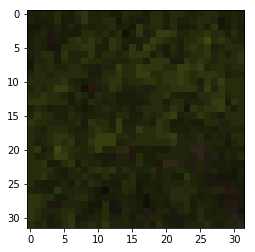

In [214]:
import matplotlib.pyplot as plt

grass = jungle_tiles[9 * 16]

plt.imshow(grass.graphics)
plt.show();

In [215]:
print(embed_mat.shape)
print(len(unique_tiles))

(5308, 32)
5308


In [217]:
tile_index, closest = min(enumerate(embed_mat), key = lambda x: np.linalg.norm(x[1] - embed_mat[tile_to_int[grass]]))
int_to_tile[tile_index]

<tileset.Tile - group 9, item 0>

In [157]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def tile_to_vec(tile):
    return embed_mat[tile_to_int[tile]]

def vec_to_tile(vec, count=1):
    similarity = lambda x: cos_sim(x, vec)
    tiles_by_similarity = sorted(enumerate(embed_mat), key = lambda x: similarity(x[1]), reverse = True)
    return [(int_to_tile[i], similarity(v)) for i, v in tiles_by_similarity[: count]]

res = tile_to_vec(grass_to_dirt) + tile_to_vec(grass) - tile_to_vec(stones)

In [165]:
vec_to_tile(res, count = 20)

[(<tileset.Tile - group 9, item 0>, 0.5770368),
 (<tileset.Tile - group 9, item 1>, 0.45686454),
 (<tileset.Tile - group 205, item 0>, 0.44884413),
 (<tileset.Tile - group 9, item 5>, 0.3732814),
 (<tileset.Tile - group 9, item 2>, 0.361319),
 (<tileset.Tile - group 9, item 9>, 0.35218728),
 (<tileset.Tile - group 9, item 3>, 0.33025903),
 (<tileset.Tile - group 227, item 0>, 0.32650447),
 (<tileset.Tile - group 8, item 4>, 0.31190956),
 (<tileset.Tile - group 9, item 4>, 0.29803804),
 (<tileset.Tile - group 1069, item 2>, 0.29663074),
 (<tileset.Tile - group 1553, item 2>, 0.29502037),
 (<tileset.Tile - group 8, item 3>, 0.2933204),
 (<tileset.Tile - group 8, item 2>, 0.29327682),
 (<tileset.Tile - group 207, item 0>, 0.28803042),
 (<tileset.Tile - group 385, item 1>, 0.2867923),
 (<tileset.Tile - group 1489, item 0>, 0.28513065),
 (<tileset.Tile - group 8, item 0>, 0.27751693),
 (<tileset.Tile - group 1516, item 1>, 0.27714443),
 (<tileset.Tile - group 8, item 9>, 0.27584574)]

За съжаление нямат семантиката, на която се надявахме. Очаквахме `grass_to_dirt + grass - stones -> stones_to_dirt`, но не се получи така.

Но плочките са подобни по между си. Изглежда все пак близките плочки имат близки вектори.

Как изглежда cosine similarity за всяка плочка спрямо избраната?

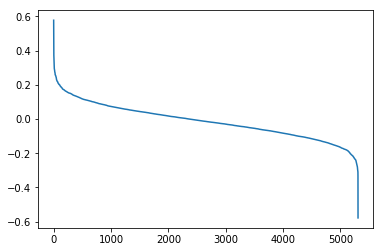

In [166]:
plt.plot([x[1] for x in vec_to_tile(res, count = len(unique_tiles))])

Можем ли да обърнем плочките в карта до вектори и да ги върнем?

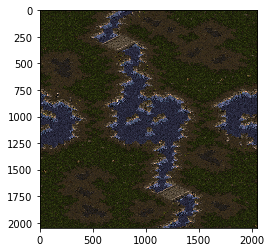

In [208]:
vectors = scenario_to_output(scenarios[0])

output_tiles = np.full([64, 64], Tileset.JUNGLE.tiles[0], dtype=object)
for i in range(64):
    for j in range(64):
        vec = vectors[i, j]
        tile, _ = vec_to_tile(vec, count=1)[0]
        output_tiles[i, j] = tile

plt.imshow(graphics.tile(output_tiles));

## Трениране на RNN с embedding-ите

In [188]:
h = 64
w = 64

input_vec_size = 2 * n_embedding
output_vec_size = n_embedding

def tile_to_output(tiles, vertical_index, horizontal_index):
    if vertical_index >= 0 and horizontal_index >= 0:
        tile = tiles[vertical_index, horizontal_index]
        return embed_mat[tile_to_int[tile]]
    else:
        return np.zeros([output_vec_size])

def tile_to_input(tiles, vertical_index, horizontal_index):
    top_features = tile_to_output(tiles, vertical_index - 1, horizontal_index)
    left_features = tile_to_output(tiles, vertical_index, horizontal_index - 1)
    return np.concatenate([top_features, left_features])

def scenario_to_input(scenario):
    h, w = scenario.shape
    result = np.empty((h, w, input_vec_size), dtype=np.float32)
    for vertical_index in range(h):
        for horizontal_index in range(w):
            result[vertical_index, horizontal_index, :] = tile_to_input(scenario.tiles, vertical_index, horizontal_index)
    return result

def scenario_to_output(scenario):
    h, w = scenario.shape
    y = np.empty((h, w, output_vec_size), dtype=np.float32)
    for vertical_index in range(h):
        for horizontal_index in range(w):
            y[vertical_index, horizontal_index, :] = tile_to_output(scenario.tiles, vertical_index, horizontal_index)
    return y

def batches(data, batch_size, epochs):
    all_batches = []
    for epoch in range(epochs):
        random.shuffle(data)
        all_batches += data

    for i in range(0, epochs * len(data), batch_size):
        inputs = all_batches[i: i + batch_size]
        if len(inputs) == batch_size:
            yield inputs


from mdlstm import *

from time import time

import tensorflow.contrib.slim as slim

def train(session, data, learning_rate=0.1, batch_size=7, hidden_size=96,epochs=10, dtype=tf.float32):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    layer1_rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    layer2_rnn_in = tf.nn.relu(layer1_rnn_out)
    layer2_rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=layer2_rnn_in, scope_n='layer2')
    model_out = slim.fully_connected(inputs=layer2_rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    session.run(tf.global_variables_initializer())

    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = session.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([scenario_to_input(scenario) for scenario in batch]),
            y: np.stack([scenario_to_output(scenario) for scenario in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break

        step += 1


two_player_scenarios = [x for x in scenarios if x.alliances == x.human_players == 2]
data = [x for x in two_player_scenarios if x.width == x.height == 64 and x.tileset == Tileset.JUNGLE]

In [190]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
with tf.variable_scope('a', reuse=tf.AUTO_REUSE):
    train(sess, data, learning_rate=0.1, batch_size=7, hidden_size=96, epochs=10)

steps = 0000 | overall loss = 0.26242 | time 58.518
steps = 0001 | overall loss = 0.23689 | time 42.678
steps = 0002 | overall loss = 0.03191 | time 44.774
steps = 0003 | overall loss = 0.01128 | time 45.386
steps = 0004 | overall loss = 0.01006 | time 44.019
steps = 0005 | overall loss = 0.01000 | time 45.317
steps = 0006 | overall loss = 0.01000 | time 45.108
steps = 0007 | overall loss = 0.01000 | time 45.022
steps = 0008 | overall loss = 0.01000 | time 46.447
steps = 0009 | overall loss = 0.01000 | time 44.596
steps = 0010 | overall loss = 0.01000 | time 47.894
steps = 0011 | overall loss = 0.01000 | time 48.473
steps = 0012 | overall loss = 0.01000 | time 44.251
steps = 0013 | overall loss = 0.01000 | time 47.465
steps = 0014 | overall loss = 0.01000 | time 47.310


## Семплиране на RNN

In [191]:
def iterate_by_layers(height, width):
    
    def iterate_layer(layer):
        for x in range(layer + 1):
            y = layer - x
            if 0 <= x < width and 0 <= y < height:
                yield (x, y)

    for layer in range(width + height - 1):
        yield iterate_layer(layer)

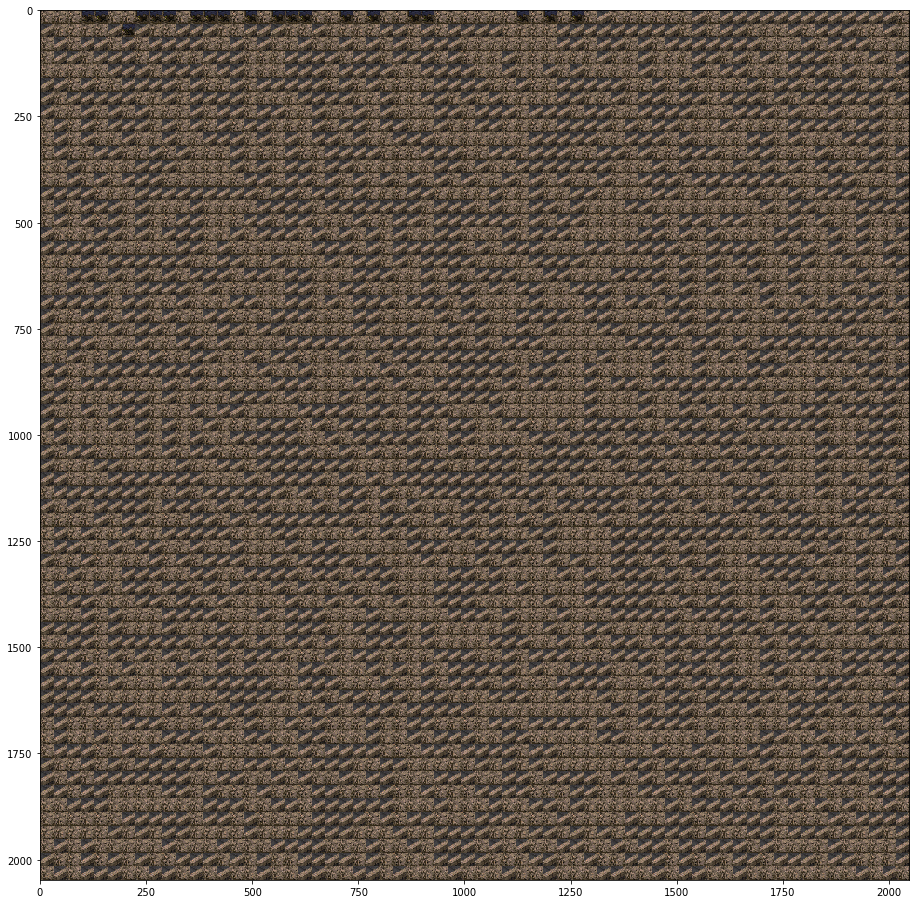

In [199]:
import graphics
import random

from IPython.display import clear_output

%matplotlib inline

hidden_size = 96

with tf.variable_scope('a', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [1, h, w, input_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    inputs = scenario_to_input(data[0]).reshape(1, 64, 64, input_vec_size)
    model_preds = sess.run(model_out, feed_dict={ x: inputs })

    output_tiles = np.full([64, 64], Tileset.JUNGLE.tiles[0], dtype=object)
    for i in range(64):
        for j in range(64):
            vec = model_preds[0, i, j]
            tile, _ = random.choice(vec_to_tile(vec, count=2))
            output_tiles[i, j] = tile

    plt.figure(figsize=(16, 16))
    plt.imshow(graphics.tile(output_tiles))
    plt.show()